### Spikes coupled to LFP

In [15]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_amplitude_encoding/")

In [34]:
from functools import partial
import os
import xarray as xr
import jax
import jax.numpy as jnp
from fooof import FOOOF
from fooof.plts.spectra import plot_spectra
from fooof.sim.gen import gen_aperiodic
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from src.models_setup import _set_nodes, _set_nodes_delayed
from src.utils import randn

#### Functions

In [3]:
jax.config.update("jax_enable_x64", True)


def _check_params(Iext: jnp.ndarray, N: int):
    if isinstance(Iext, (int, float)):
        return jnp.ones((1, N)) * Iext  # Assure it is a jax ndarray
    elif Iext is None:
        return jnp.zeros((1, N))
    return jnp.asarray(Iext)


def _ode(Z: np.complex128, a: float, w: float):
    return Z * (a + 1j * w - jnp.abs(Z) ** 2)


def ode_spikes(v, vr, tau):
    return -(v - vr) / tau

In [4]:
def simulate_SpikeLFP(
    lfp2spike: float,
    f: float,
    a: float,
    vth: float,
    vr: float,
    tau: float,
    fs: float,
    eta: float,
    T: float,
    seed: int = 0,
    device: str = "cpu",
    decim: int = 1,
):

    assert device in ["cpu", "gpu"]

    jax.config.update("jax_platform_name", device)

    dt = 1 / fs

    times = np.arange(T, dtype=int)  # Time array

    omega = 2 * jnp.pi * f

    # Initialize phase and membrane potential
    z = dt * np.random.uniform() + 1j * dt * np.random.uniform()
    v_t = np.random.uniform() * (vth - vr) + vr
    x_t = False

    # Neuron noise parameter
    R = 50.0  # Membrane resistence in Mohm
    sigma = 2.12  # Noise variance
    Cm = tau / R
    x_ex = jnp.exp(dt / tau)

    mu_v = 14.2 / R
    sigma_v = sigma * (Cm / tau) * jnp.sqrt((1 + x_ex) / (1 - x_ex))

    # Scale with dt to avoid doing it evert time-step
    eta = eta * jnp.sqrt(dt)

    # @jax.jit
    def _loop(carry, t):

        z, v_t, x_t = carry

        z = (
            z
            + dt * _ode(z, a, omega)
            + eta * randn(size=1, seed=seed + t)[0]
            + eta * 1j * randn(size=1, seed=seed + t + 2 * t)[0]
        )

        v_t = (
            v_t
            + dt * ode_spikes(v_t, vr, tau)
            + jnp.sqrt(dt) * (mu_v + sigma * randn(size=1, seed=seed + t + 15)[0])
            + dt * lfp2spike * jax.nn.relu(z.real * 1e6)
        )

        x_t = v_t >= vth

        v_t = x_t * vr + (1 - x_t) * v_t

        carry = (z, v_t, x_t)
        return carry, (z, v_t, x_t)

    _, out = jax.lax.scan(_loop, (z, v_t, x_t), times)

    return out[0][::decim], out[1][::decim], out[2][::decim]

In [5]:
def simulate_SpikeLFP_network(
    W: float,
    M: float,
    G: float,
    E: float,
    g,
    f: float,
    a: float,
    vth: float,
    vr: float,
    tau: float,
    fs: float,
    eta: float,
    T: float,
    seed: int = 0,
    device: str = "cpu",
    decim: int = 1,
):

    assert device in ["cpu", "gpu"]

    jax.config.update("jax_platform_name", device)

    # Number of regions
    N = len(W)

    g = _check_params(g, T).squeeze()
    eta = _check_params(eta, N).squeeze()

    # Temporal resolution
    dt = 1 / fs

    # Time array
    times = np.arange(T, dtype=int)  # Time array

    omega = 2 * jnp.pi * f

    # Initialize phase and membrane potential
    z = dt * np.random.uniform(size=(N, 1)) + 1j * dt * np.random.uniform(size=(N, 1))
    v = np.random.uniform(size=(N, 1)) * (vth - vr) + vr
    x = np.zeros((N, 1), dtype=jnp.bool)

    # Neuron noise parameter
    R = 50.0  # Membrane resistence in Mohm
    sigma = 2.12 * jnp.sqrt(dt)  # Noise variance
    mu_v = 14.2 / R * jnp.sqrt(dt)

    # Scale with dt to avoid doing it evert time-step
    eta = eta * jnp.sqrt(dt)

    # Scale with dt to avoid doing it evert time-step
    W = W * dt
    M = M * dt
    G = G * dt
    E = E * dt

    # @jax.jit
    def _loop(carry, t):

        z, v, x = carry

        z_t = z.squeeze().copy()
        v_t = v.squeeze().copy()
        x_t = x.squeeze().copy()

        z_differences = z_t - z

        # Input to each node
        input_LFP = g[t] * (W * z_differences).sum(axis=1)
        input_SPIKES2LFP = g[t] * (G * x_t).sum(axis=1)
        input_SPIKES = g[t] * (M * x_t).sum(axis=1) / tau

        z = z.at[:, 0].set(
            z_t
            + dt * _ode(z_t, a, omega)
            + input_LFP
            + input_SPIKES2LFP
            + eta * randn(size=(N,), seed=seed + t)
            + eta * 1j * randn(size=(N,), seed=seed + t + 2 * t)
        )

        v = v.at[:, 0].set(
            v_t
            + dt * ode_spikes(v_t, vr, tau)
            + input_SPIKES
            + mu_v
            + sigma * randn(size=(N,), seed=seed + t + 15)
            + E * jax.nn.relu(z_t.real * 1e6)
        )

        # Check threshold crossing
        x = v >= vth
        v = x * vr + (1 - x) * v

        carry = (z, v, x)
        return carry, (z, v, x)

    _, out = jax.lax.scan(_loop, (z, v, x), times)

    return out[0][..., ::decim], out[1][..., ::decim], out[2][..., ::decim]

#### One region

In [6]:
out = [
    simulate_SpikeLFP(5, 40, -5, -50, -70, 20, 1 / 1e-4, 1e-4, 100000, seed=i + 20546)
    for i in tqdm(range(50))
]

100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.73it/s]


In [7]:
z = np.stack([out_[0].real for out_ in out])
x = np.stack([out_[2] for out_ in out])

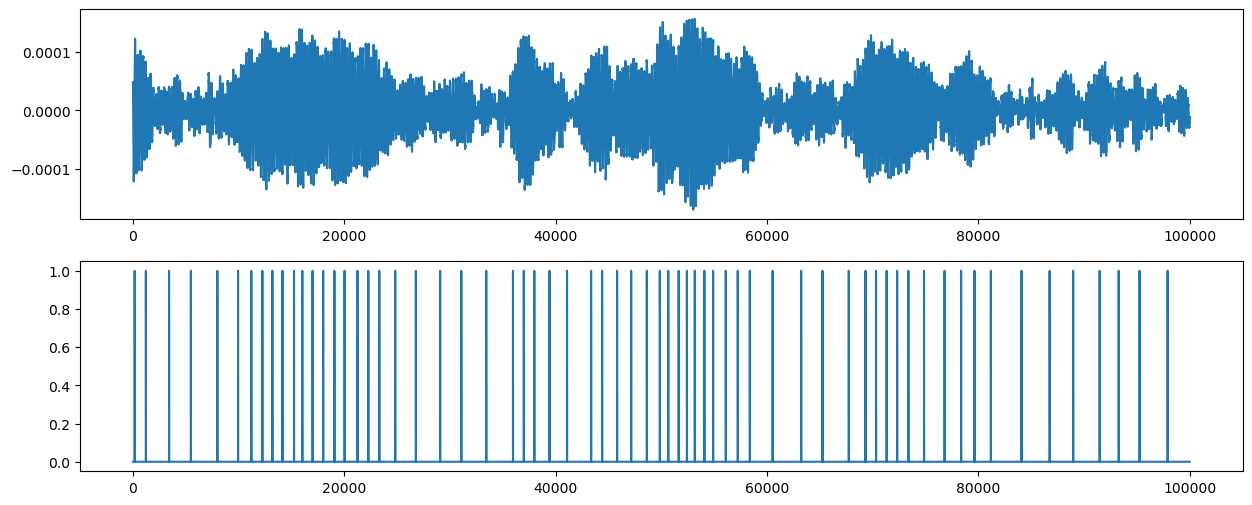

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(z[0])
plt.subplot(2, 1, 2)
plt.plot(x[0])

#### Two regions

In [13]:
W = jnp.array([[0, 1], [0, 0]]).T * 30
M = jnp.array([[0, 1], [0, 0]]).T * 0.25
G = jnp.array([[0, 1], [0, 0]]).T * 3
E = jnp.array([15, 15])

g = 1
f = jnp.array([40, 40])
a = -10
vth = -50
vr = -70
tau = 20
fs = 1 / 1e-4
eta = 1e-4
T = 50000

In [17]:
z, v, x = simulate_SpikeLFP_network(W, M, G, E, g, f, a, vth, vr, tau, fs, eta, T)

Text(0, 0.5, 'Spike Train')

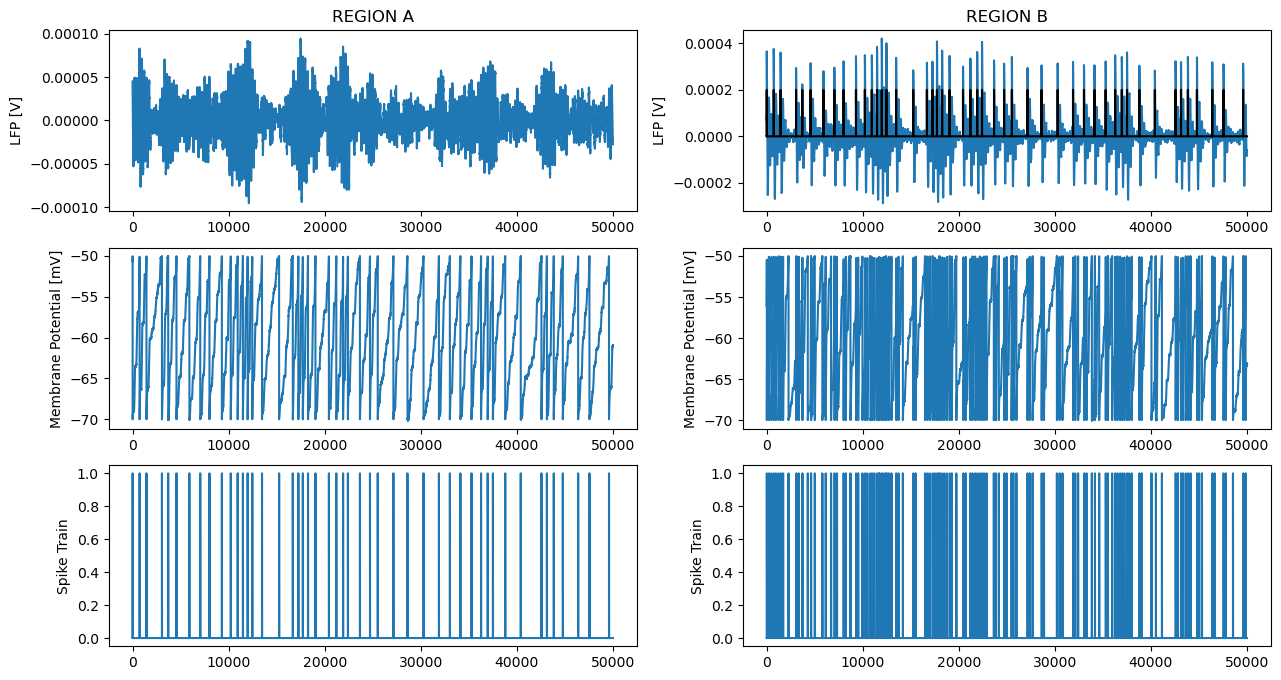

In [18]:
plt.figure(figsize=(15, 8))
# LFP
plt.subplot(3, 2, 1)
plt.plot(z.real[:, 0])
plt.title("REGION A")
plt.ylabel("LFP [V]")
plt.subplot(3, 2, 2)
plt.plot(z.real[:, 1])
plt.plot(x[:, 0] / 5000, c="k")

plt.title("REGION B")
plt.ylabel("LFP [V]")


# POTENTIAL
plt.subplot(3, 2, 3)
plt.plot(v[:, 0])
plt.ylabel("Membrane Potential [mV]")
plt.subplot(3, 2, 4)
plt.plot(v[:, 1])
plt.ylabel("Membrane Potential [mV]")

# SPIKE TRAIN
plt.subplot(3, 2, 5)
plt.plot(x[:, 0])
plt.ylabel("Spike Train")
plt.subplot(3, 2, 6)
plt.plot(x[:, 1])
plt.ylabel("Spike Train")


### Whole-brain model

######################################################################################
#### FUNCTIONS
######################################################################################

In [26]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    roi_c = np.c_[x_s, x_t]
    idx = np.argsort(np.char.lower(roi_c.astype(str)), axis=1)
    roi_s, roi_t = np.c_[[r[i] for r, i in zip(roi_c, idx)]].T
    return roi_s, roi_t

######################################################################################
#### LOAD EMPIRICAL POWER SPECTRA
######################################################################################

In [19]:
areas_data = np.array(
    [
        "AIP",
        "Caudate",
        "Claustrum",
        "Core",
        "DP",
        "F1",
        "F2",
        "F6",
        "F7",
        "FST",
        "Ins",
        "LIP",
        "MB",
        "MIP",
        "MST",
        "MT",
        "OPRO",
        "PBr",
        "PIP",
        "Putamen",
        "SII",
        "STPc",
        "TPt",
        "Thal",
        "V1",
        "V2",
        "V3",
        "V3A",
        "V4",
        "V4t",
        "V6A",
        "VIP",
        "a1",
        "a11",
        "a12",
        "a13",
        "a14",
        "a2",
        "a23",
        "a24D",
        "a24c",
        "a3",
        "a32",
        "a44",
        "a45A",
        "a45B",
        "a46D",
        "a46V",
        "a5",
        "a7A",
        "a7B",
        "a7M",
        "a7op",
        "a8B",
        "a8L",
        "a8M",
        "a8r",
        "a9/46D",
        "a9/46V",
    ],
    dtype=object,
)


area_names = [
    "V1",
    "V2",
    "V4",
    "DP",
    "MT",
    "a8M",
    "a5",
    "a8L",
    "TEO",  ##
    "a2",
    "F1",
    "STPc",
    "a7A",
    "a46D",
    "10",  ##
    "a9/46V",
    "a9/46D",
    "F5",  ##
    "TEpd",  ##
    "PBr",
    "a7M",
    "a7B",
    "F2",
    "STPi",  ##
    "PROm",  ##
    "F7",
    "a8B",
    "STPr",  ##
    "a24c",
]

In [22]:
session_numbers = os.listdir("/home/INT/lima.v/Results/phase_encoding/psd/lucy")

In [27]:
sxx, peak_freqs, peak_power = [], [], []

for session in tqdm(session_numbers):

    sxx_ = xr.load_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session}/sxx.nc"
    )
    peak_freqs_ = xr.load_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session}/peak_freqs.nc"
    )
    peak_power_ = xr.load_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session}/peak_power.nc"
    )

    _, roi_data = _extract_roi(peak_freqs_.roi.values, "_")
    sxx_ = sxx_.assign_coords({"roi": roi_data}).groupby("roi").mean("roi")
    peak_freqs_ = (
        peak_freqs_.assign_coords({"roi": roi_data}).groupby("roi").mean("roi")
    )
    peak_power_ = (
        peak_power_.assign_coords({"roi": roi_data}).groupby("roi").mean("roi")
    )

    sxx += [sxx_]
    peak_freqs += [peak_freqs_]
    peak_power += [peak_power_]

100%|███████████████████████████████████████████| 62/62 [00:00<00:00, 76.99it/s]


In [28]:
peak_freqs = xr.concat(peak_freqs, "sessions").mean("sessions")[0]
peak_power = xr.concat(peak_power, "sessions").mean("sessions")[0]

In [29]:
# Data power spectrum
sxx_data = xr.concat(sxx, "sessions").mean("sessions").groupby("roi").mean("roi")[0]
# sxx_data = sxx_data / sxx_data.max("freqs")

In [30]:
unique_rois = sxx_data.roi.values

sca = ["Caudate", "Claustrum", "Thal", "Putamen"]

idx = np.logical_not([s in sca for s in unique_rois])

unique_rois[idx]

array(['AIP', 'Core', 'DP', 'F1', 'F2', 'F6', 'F7', 'FST', 'Ins', 'LIP',
       'MB', 'MIP', 'MST', 'MT', 'OPRO', 'PBr', 'PIP', 'SII', 'STPc',
       'TPt', 'V1', 'V2', 'V3', 'V3A', 'V4', 'V4t', 'V6A', 'VIP', 'a1',
       'a11', 'a12', 'a13', 'a14', 'a2', 'a23', 'a24D', 'a24c', 'a3',
       'a32', 'a44', 'a45A', 'a45B', 'a46D', 'a46V', 'a5', 'a7A', 'a7B',
       'a7M', 'a7op', 'a8B', 'a8L', 'a8M', 'a8r', 'a9/46D', 'a9/46V'],
      dtype=object)

######################################################################################
#### FLATTEN DATA PSD
######################################################################################

In [35]:
freqs = sxx_data.freqs.data

sxx_data_flat = []

for roi in unique_rois:

    fm = FOOOF(verbose=False)

    spectrum = sxx_data.sel(roi=roi).values

    fm.add_data(freqs, spectrum, [1, 80])
    fm.fit(freqs, spectrum, [1, 80])

    init_ap_fit = gen_aperiodic(
        fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum)
    )

    sxx_data_flat += [fm.power_spectrum - init_ap_fit]

sxx_data.values = np.stack(sxx_data_flat)

######################################################################################
#### FIT MODEL TO DATA
######################################################################################

In [36]:
# Swap parameters


if not (
    os.path.isfile("notebooks/data/f_model.nc")
    and os.path.isfile("notebooks/data/a_model.nc")
    and os.path.isfile("notebooks/data/beta_model.nc")
):

    simulate_vmap = jax.vmap(
        simulate,
        in_axes=(None, None, 0, 0, None, 0, None, None, None, None, None, None),
    )

    beta_vec = np.linspace(1e-5, 1e-2, 30)
    f_vec = np.linspace(0.1, 80, 30)
    a_vec = np.linspace(-15, -2, 30)

    params = np.array(np.meshgrid(a_vec, f_vec, beta_vec)).T.reshape(-1, 3)

    n_trials = 50
    dt = 1e-4
    fsamp = 1 / dt
    time = np.arange(0, 0.4, 1 / fsamp)
    beta = 1e-4
    Npoints = len(time)
    decim = 10

    out = []

    for i in tqdm(range(n_trials)):

        out += [
            simulate_vmap(
                np.zeros(1),
                0,
                params[:, 1],
                params[:, 0],
                fsamp,
                params[:, 2],
                Npoints,
                None,
                0,
                "cpu",
                decim,
                "both",
            )
        ]

    data = xr.DataArray(
        np.stack(out).real,
        dims=("trials", "roi", "time"),
        coords=(range(50), range(len(params)), time[::decim]),
        attrs={"fsample": 1000},
    )

    sxx_sim = xr_psd_array_multitaper(data, bandwidth=5, n_jobs=5)
    sxx_sim = sxx_sim / sxx_sim.max("freqs")

    optm = []

    for roi in tqdm(unique_rois):

        mse = [
            mean_squared_error(sxx_data.sel(roi=roi), sxx_sim_) for sxx_sim_ in sxx_sim
        ]
        optm += [params[np.argmin(mse), :]]

    a_values, peak_freqs, beta_values = np.stack(optm).T

    peak_freqs = xr.DataArray(peak_freqs, dims=("roi"), coords=(unique_rois,))
    a_values = xr.DataArray(a_values, dims=("roi"), coords=(unique_rois,))
    beta_values = xr.DataArray(beta_values, dims=("roi"), coords=(unique_rois,))

    f_model = []

    for area in area_names:
        if area in peak_freqs.roi.values:
            f_model += [peak_freqs.sel(roi=area)]
        else:
            f_model += [-1]

    f_model = xr.DataArray(f_model, dims=("roi"), coords=(area_names,))

    f_model.values[8] = f_model.values[7]
    f_model.values[14] = f_model.values[13]
    f_model.values[17] = f_model.values[16]
    f_model.values[18] = f_model.values[17]
    f_model.values[23] = f_model.values[22]
    f_model.values[24] = f_model.values[23]
    f_model.values[27] = f_model.values[26]
    f_model = f_model.fillna(f_model.min())

    a_model = []

    for area in area_names:
        if area in peak_freqs.roi.values:
            a_model += [a_values.sel(roi=area)]
        else:
            a_model += [-1]

    a_model = xr.DataArray(a_model, dims=("roi"), coords=(area_names,))

    a_model.values[8] = a_model.values[7]
    a_model.values[14] = a_model.values[13]
    a_model.values[17] = a_model.values[16]
    a_model.values[18] = a_model.values[17]
    a_model.values[23] = a_model.values[22]
    a_model.values[24] = a_model.values[23]
    a_model.values[27] = a_model.values[26]

    beta_model = []

    for area in area_names:
        if area in beta_values.roi.values:
            beta_model += [beta_values.sel(roi=area)]
        else:
            beta_model += [-1]

    beta_model = xr.DataArray(beta_model, dims=("roi"), coords=(area_names,))

    beta_model.values[8] = beta_model.values[7]
    beta_model.values[14] = beta_model.values[13]
    beta_model.values[17] = beta_model.values[16]
    beta_model.values[18] = beta_model.values[17]
    beta_model.values[23] = beta_model.values[22]
    beta_model.values[24] = beta_model.values[23]
    beta_model.values[27] = beta_model.values[26]

    f_model.to_netcdf("data/f_model.nc")
    a_model.to_netcdf("data/a_model.nc")
    beta_model.to_netcdf("data/beta_model.nc")

else:

    f_model = xr.load_dataarray("data/f_model.nc")
    a_model = xr.load_dataarray("data/a_model.nc")
    beta_model = xr.load_dataarray("data/beta_model.nc")

FileNotFoundError: [Errno 2] No such file or directory: '/home/INT/lima.v/projects/phase_amplitude_encoding/data/f_model.nc'